# Test of hierarchical classification (model 1)

  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then only those sources classified as Stochastic pass through the stochastic layer, only those classified as Transient pass through the transient layer, and only those sources classified as Periodic pass through the periodic layer. 

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier

  ### Definition of names for plots and files

In [2]:
morethan5 = False

date = '20190925'

#names of files with detections, features and labels for the training set (v3)
labels_file = '../alerce_trainingset/training_set_v3/labels.pkl'
detections_file = '../alerce_trainingset/training_set_v3/detections.pkl'
#features_file = '../alerce_trainingset/training_set_v3/features.pkl'
features_file = '../ZTF_data/features_20190926.pickle'
non_detections_file = '../alerce_trainingset/training_set_v3/training_non_det_v3.h5'

#where the RF models are saved
if morethan5:
    
    model_first_layer = 'stat_hierRF_model_1/rf_model_1_hierarchical_layer_morethan5gr_'+date
    model_periodic_layer = 'stat_hierRF_model_1/rf_model_1_periodic_layer_morethan5gr_'+date
    model_transient_layer = 'stat_hierRF_model_1/rf_model_1_transient_layer_morethan5gr_'+date
    model_stochastic_layer = 'stat_hierRF_model_1/rf_model_1_stochastic_layer_morethan5gr_'+date

else:
    
    model_first_layer = 'stat_hierRF_model_1/rf_model_1_hierarchical_layer_'+date
    model_periodic_layer = 'stat_hierRF_model_1/rf_model_1_periodic_layer_'+date
    model_transient_layer = 'stat_hierRF_model_1/rf_model_1_transient_layer_'+date
    model_stochastic_layer = 'stat_hierRF_model_1/rf_model_1_stochastic_layer_'+date

#confusion matrixes

if morethan5:
    conf_matrix_name_first_layer = 'stat_hierRF_model_1/confusion_matrix_rf_model_1_hierarchical_layer_morethan5gr_'+date
    conf_matrix_name_second_layer = 'stat_hierRF_model_1/confusion_matrix_rf_model_1_multiclass_morethan5gr_'+date

else:
    conf_matrix_name_first_layer = 'stat_hierRF_model_1/confusion_matrix_rf_model_1_hierarchical_layer_'+date
    conf_matrix_name_second_layer = 'stat_hierRF_model_1/confusion_matrix_rf_model_1_multiclass_'+date

#feature importances

if morethan5:
    feature_importance_name_first_layer = 'stat_hierRF_model_1/feature_importance_rf_model_1_hierarchical_layer_morethan5gr_'+date
    feature_importance_name_periodic_layer = 'stat_hierRF_model_1/feature_importance_rf_model_1_periodic_layer_morethan5gr_'+date
    feature_importance_name_transient_layer = 'stat_hierRF_model_1/feature_importance_rf_model_1_transient_layer_morethan5gr_'+date
    feature_importance_name_stochastic_layer = 'stat_hierRF_model_1/feature_importance_rf_model_1_stochastic_layer_morethan5gr_'+date

else:
    feature_importance_name_first_layer = 'stat_hierRF_model_1/feature_importance_rf_model_1_hierarchical_layer_'+date
    feature_importance_name_periodic_layer = 'stat_hierRF_model_1/feature_importance_rf_model_1_periodic_layer_'+date
    feature_importance_name_transient_layer = 'stat_hierRF_model_1/feature_importance_rf_model_1_transient_layer_'+date
    feature_importance_name_stochastic_layer = 'stat_hierRF_model_1/feature_importance_rf_model_1_stochastic_layer_'+date

### reading the training set files 

In [3]:
df_nd = pd.read_hdf(non_detections_file)
df_feat = pd.read_pickle(features_file)
df_labels = pd.read_pickle(labels_file)
df_detections = pd.read_pickle(detections_file)

#deleting columns in df_nd with name ending in "_3"
for col in list(df_nd):
    if col[-2:] == "_3":
        df_nd.drop(col, inplace=True, axis=1)

#getting gscore from the detections file
df_det = df_detections.groupby(['oid'])
df_sgscore = df_det['sgscore1'].median()
df_sgscore = df_sgscore.to_frame()

#creating color features
#df_nd["g_r_max"] = df_nd.min_mag_fid_1 - df_nd.min_mag_fid_2
#df_feat["g_r_mean"] = df_feat.Mean_1 - df_feat.Mean_2

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)


In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['class_source'] == 'RS CVn'), 'class_original'] = 'RS-CVn'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'

#defining the classes included in the RF model
label_order = ['AGN-I', 'Blazar', 'CV/Nova', 'LPV', 'SNIa', 'SNIbc', 'SNII',
               'SLSN', 'EBSD/D', 'EBC', 'DSCT', 'RRL', 'Ceph', 'RS-CVn', 'Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[(labels['class_hierachical'] == 'EBSD/D') | (labels['class_hierachical'] == 'EBC')  | (labels['class_hierachical'] == 'RS-CVn') | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'Ceph')  | (labels['class_hierachical'] == 'Periodic-Other'), 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')| (labels['class_hierachical'] == 'AGN-I') | (labels['class_hierachical'] == 'Blazar')  | (labels['class_hierachical'] == 'LPV') , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Stochastic','Transient','Periodic']
cm_classes_original = label_order

labels.head()

,class_original,class_hierachical
oid,,
ZTF17aacjwvd,EBSD/D,Periodic
ZTF17aadecrr,EBSD/D,Periodic
ZTF18adaksvf,RS-CVn,Periodic
ZTF18abtqdih,EBC,Periodic
ZTF18abshynt,LPV,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_fid_1',
'n_det_fid_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',]
'''
'max_mjd_fid_1',
'max_mjd_fid_2',
'min_mjd_fid_1',
'min_mjd_fid_2',
'max_mag_fid_1',
'max_mag_fid_2',
'min_mag_fid_1',
'min_mag_fid_2',
'first_mag_fid_1',
'first_mag_fid_2',
'first_mjd_fid_1',
'first_mjd_fid_2']
'''

#combining all the DF
#df = labels.join(df_sgscore).join(df_feat).join(df_nd.drop(rm_nd_cols, axis=1))
df = labels.join(df_sgscore).join(df_feat.drop(rm_nd_cols, axis=1))
df.drop(['Mean_1', 'Mean_2', 'g-r_mean','class_original','class_hierachical'], axis=1, inplace=True)
df.fillna(-999,inplace=True)

if morethan5:
    df = df[(df.n_samples_1 > 5) & (df.n_samples_2 > 5)]
    labels = labels.loc[df.index.values]

df.head()

,sgscore1,delta_mag_fid_1,delta_mag_fid_2,delta_mjd_fid_1,delta_mjd_fid_2,dmag_first_det_fid_1,dmag_first_det_fid_2,dmag_non_det_fid_1,dmag_non_det_fid_2,g-r_max,...,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,GP_DRW_sigma_2,GP_DRW_tau_2,IAR_phi_2,LinearTrend_2,gal_b,gal_l
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aacjwvd,0.995625,0.424199,0.378390,271.098183,308.101134,2.543534,2.714242,2.939435,3.789690,0.917404,...,1.000000,9.320852e-05,0.241617,0.002623,2.522917e-02,0.255101,0.000084,0.000277,20.470856,185.723835
ZTF17aadecrr,0.995417,0.935824,0.491198,347.994942,304.160069,5.238234,-999.000000,5.504596,-999.000000,0.964960,...,1.000000,1.113585e-04,0.249795,0.102750,2.051202e-02,0.620047,0.187446,0.000486,-8.541295,190.823524
ZTF18adaksvf,0.999167,0.229270,0.600738,113.687512,192.702361,2.992945,4.185538,3.222215,4.412964,0.876349,...,1.000000,1.268727e-04,0.200540,-0.118095,2.028384e-02,0.525963,0.029509,-0.000960,64.283014,275.075197
ZTF18abtqdih,0.962042,0.355823,0.210677,376.014641,381.944410,6.048240,-999.000000,5.901356,-999.000000,0.630459,...,0.231151,-3.693538e-05,0.000000,0.000000,5.421010e-08,0.642937,0.513844,-0.000073,-33.524393,127.583847
ZTF18abshynt,0.986042,0.000000,0.096107,0.000000,127.756667,2.004425,3.774174,2.004425,4.262174,2.506249,...,0.700503,-9.363979e-08,0.000000,0.000000,1.302898e-09,1.001022,0.001090,0.000237,13.026900,9.935559


  ### Defining functions to plot the confusion matrix and the feature importance

In [6]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    if morethan5: title='Confusion matrix for more than 5 samples per band'

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()
    
    
def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(model.feature_importances_))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name)
    #plt.close()

### Pre-processing training data

In [7]:
Y_hierarchical = labels['class_hierachical']#.values
Y_original = labels['class_original']#.values

X_hierarchical = df#.columns.values.tolist()

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
Y_hierarchical, Y_original, test_size=0.3, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

35623 24190 662


  ## Balanced random forest
  
  ### First layer

In [8]:
#Training first layer of the RF model

rf_model_hierarchical = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_hierarchical.fit(X_train_hierarchical, y_train_hierarchical)

#testing first layer performance

y_true, y_pred = y_test_hierarchical, rf_model_hierarchical.predict(X_test_hierarchical)
y_pred_proba_hier = rf_model_hierarchical.predict_proba(X_test_hierarchical)

#c = np.c_[y_pred_proba_hier, y_test_original]
#c = np.c_[c, y_pred_]
#print(c)

print("Accuracy:", metrics.accuracy_score(y_true, y_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true, y_pred))

#Dumping trained model

features_hierarchical = list(X_hierarchical)

with open(model_first_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_hierarchical,
            'features': features_hierarchical,
            }
        pickle.dump(model_dump, pickle_file)

Accuracy: 0.9625371349203287
Balanced accuracy: 0.9674482513715003


[[10051   108   208]
 [    7   276     0]
 [  647     1 14621]]
Normalized confusion matrix


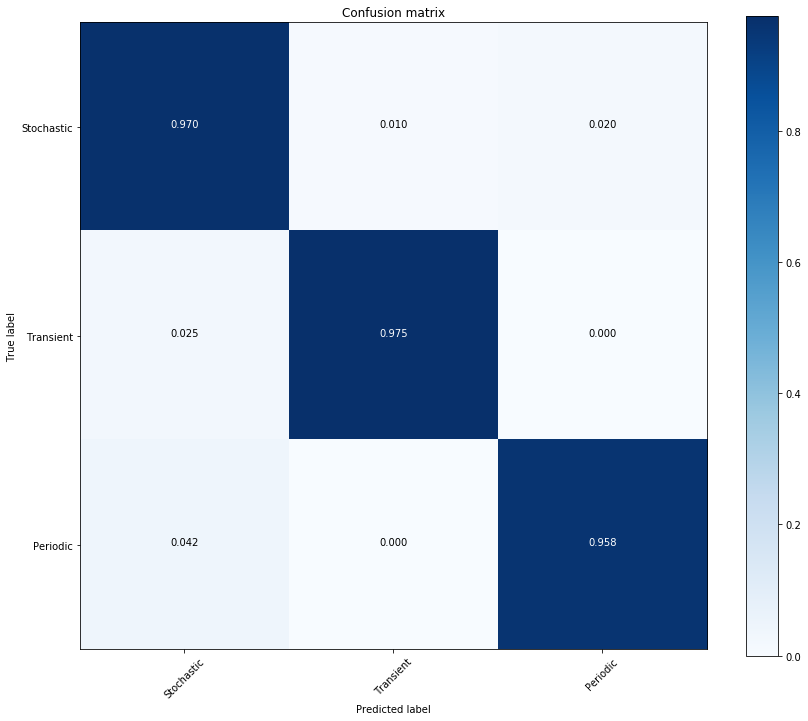

In [9]:
#plotting confusion matrix
cnf_matrix = metrics.confusion_matrix(y_true, y_pred, labels=cm_classes_hierachical)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_hierachical,conf_matrix_name_first_layer)

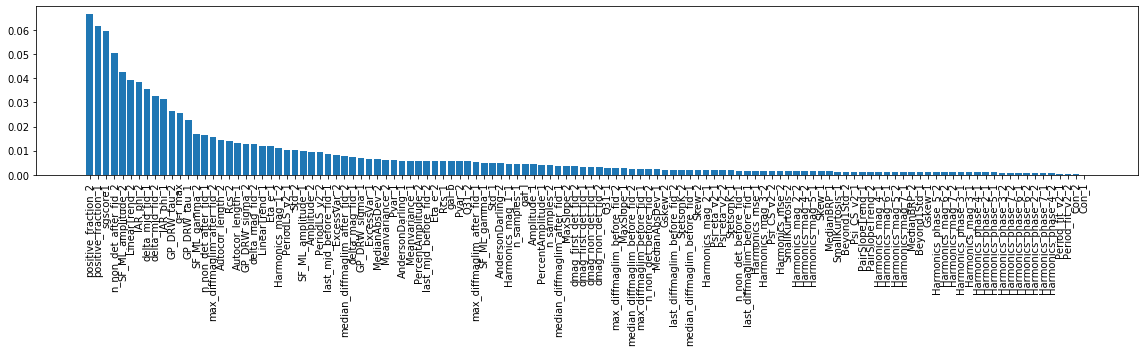

In [10]:
#plotting feature importance
plot_feature_importances(rf_model_hierarchical, features_hierarchical, feature_importance_name_first_layer)

Text(0.5, 1.0, 'sources classified as Transient')

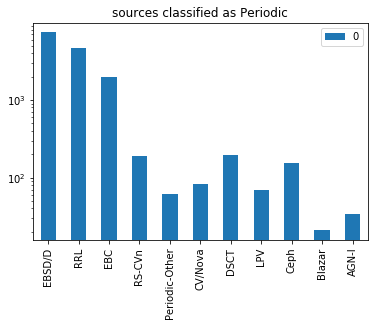

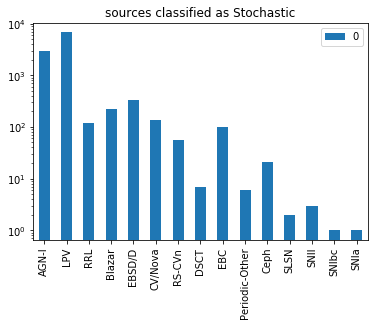

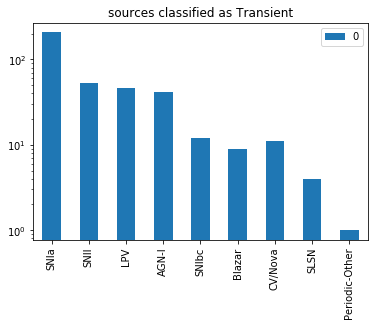

In [11]:
# separating classes (according to the predicted classification):

y_test_periodic = y_test_original.loc[y_pred=='Periodic']
X_test_periodic = X_test_hierarchical.loc[y_pred=='Periodic',:]

y_test_stochastic = y_test_original.loc[y_pred=='Stochastic']
X_test_stochastic = X_test_hierarchical.loc[y_pred=='Stochastic',:]

y_test_transient = y_test_original.loc[y_pred=='Transient']
X_test_transient = X_test_hierarchical.loc[y_pred=='Transient',:]


letter_counts = Counter(y_test_periodic)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as Periodic')

letter_counts = Counter(y_test_stochastic)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as Stochastic')

letter_counts = Counter(y_test_transient)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
plt.yscale('log')
plt.title('sources classified as Transient')





  ### Periodic layer

In [12]:
#Training Periodic layer

rf_model_periodic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_periodic.fit(X_train_periodic, y_train_periodic)


#testing Periodic layer performance

y_true_periodic, y_pred_periodic = y_test_periodic, rf_model_periodic.predict(X_test_periodic)

y_pred_proba_periodic = rf_model_periodic.predict_proba(X_test_periodic)

print("Accuracy:", metrics.accuracy_score(y_true_periodic, y_pred_periodic))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_periodic, y_pred_periodic))

classes_order_proba_periodic = rf_model_periodic.classes_
print(classes_order_proba_periodic)


#Dumping trained model

features_periodic = list(X_train_periodic)

with open(model_periodic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_periodic,
            'features': features_periodic,
            }
        pickle.dump(model_dump, pickle_file)

Accuracy: 0.5261312293478994
Balanced accuracy: 0.3937262429971318
['Ceph' 'DSCT' 'EBC' 'EBSD/D' 'Periodic-Other' 'RRL' 'RS-CVn']


In [13]:
#plotting confusion matrix
#cnf_matrix = metrics.confusion_matrix(y_true_periodic, y_pred_periodic, labels=cm_classes_original)
#plot_confusion_matrix(cnf_matrix,cm_classes_original,'test')

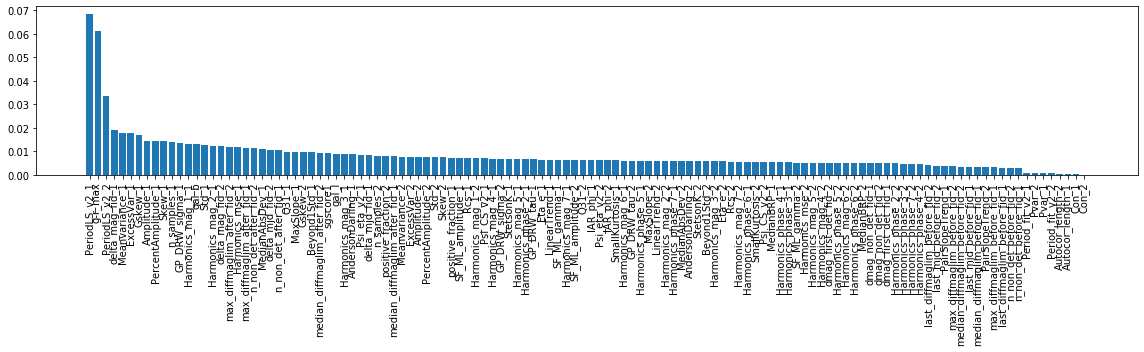

In [14]:
#plotting feature importance
plot_feature_importances(rf_model_periodic, features_periodic, feature_importance_name_periodic_layer)

  ### Stochastic layer

In [15]:
#Training Stochastic layer

rf_model_stochastic = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_stochastic.fit(X_train_stochastic, y_train_stochastic)


#testing Stochastic layer performance

y_true_stochastic, y_pred_stochastic = y_test_stochastic, rf_model_stochastic.predict(X_test_stochastic)

y_pred_proba_stochastic = rf_model_stochastic.predict_proba(X_test_stochastic)

print("Accuracy:", metrics.accuracy_score(y_true_stochastic, y_pred_stochastic))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_stochastic, y_pred_stochastic))

classes_order_proba_stochastic = rf_model_stochastic.classes_
print(classes_order_proba_stochastic)

#Dumping trained model

features_stochastic = list(X_train_stochastic)

with open(model_stochastic_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_stochastic,
            'features': features_stochastic,
            }
        pickle.dump(model_dump, pickle_file)

Accuracy: 0.8813638486688463
Balanced accuracy: 0.21667364335818826
['AGN-I' 'Blazar' 'CV/Nova' 'LPV']


In [16]:
#plotting confusion matrix
#cnf_matrix = metrics.confusion_matrix(y_true_stochastic, y_pred_stochastic, labels=cm_classes_original)
#plot_confusion_matrix(cnf_matrix,cm_classes_original,'test')

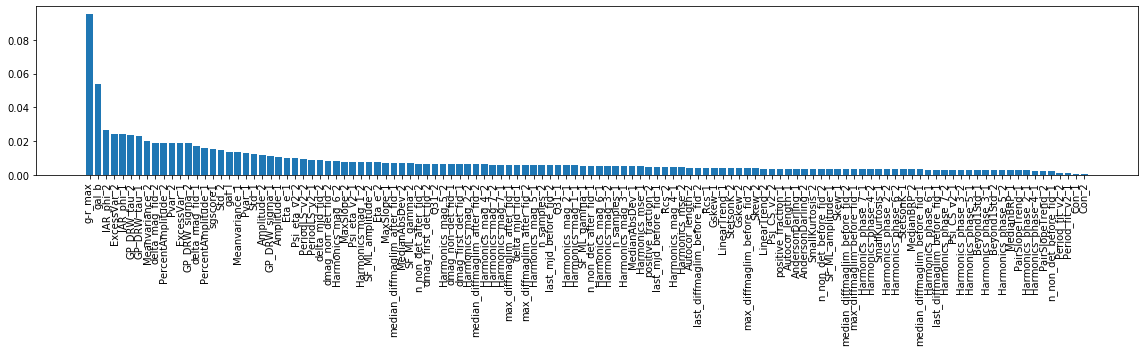

In [17]:
#plotting feature importance
plot_feature_importances(rf_model_stochastic, features_stochastic, feature_importance_name_stochastic_layer)

  ### Transient layer

In [18]:
#Training Transient layer

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='auto',
            max_depth=None,
            n_jobs=1,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)


#testing Transient layer performance

y_true_transient, y_pred_transient = y_test_transient, rf_model_transient.predict(X_test_transient)

y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

print("Accuracy:", metrics.accuracy_score(y_true_transient, y_pred_transient))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_transient, y_pred_transient))

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as pickle_file:
        model_dump = {
            'rf_model': rf_model_transient,
            'features': features_transient,
            }
        pickle.dump(model_dump, pickle_file)

Accuracy: 0.42597402597402595
Balanced accuracy: 0.24519440140167514
['SLSN' 'SNII' 'SNIa' 'SNIbc']


In [19]:
#plotting confusion matrix
#cnf_matrix = metrics.confusion_matrix(y_true_transient, y_pred_transient, labels=cm_classes_original)
#plot_confusion_matrix(cnf_matrix,cm_classes_original,'test')

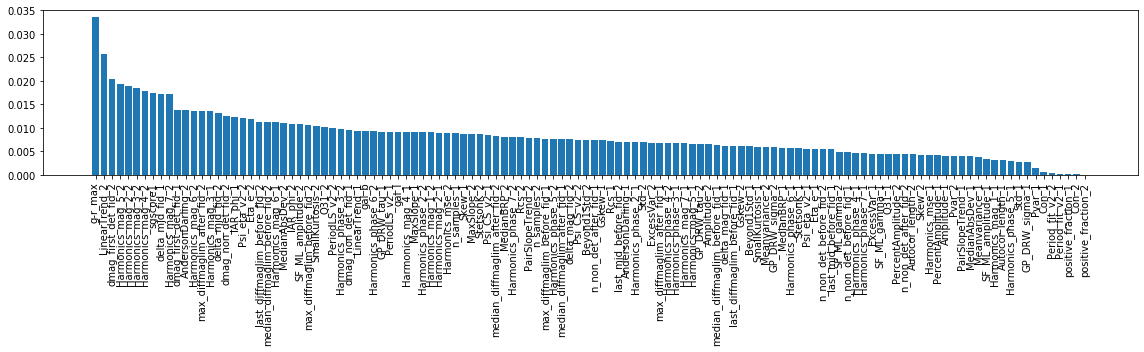

In [20]:
#plotting feature importance
plot_feature_importances(rf_model_transient, features_transient, feature_importance_name_transient_layer)

 ## Putting al layers together  

[[2562  357   16   12    3    4   20   15    2    4    5    8    2    2
    11]
 [  65  137   13    5    2    3    2    2    1    5    1    5    1    3
     5]
 [  10   18  107    3    8    1    0    2    2   15   15   25   19    1
     6]
 [  43   39   35 6629    0   30    5   11    1    5    8    0   12   26
    18]
 [   0    0    0    1  131   43   10   23    0    0    0    0    0    0
     0]
 [   0    1    0    0    7    4    1    0    0    0    0    0    0    0
     0]
 [   1    2    0    0    5    9   26   13    0    0    0    0    0    0
     0]
 [   0    2    0    0    0    1    0    3    0    0    0    0    0    0
     0]
 [ 209   76   20   33    0    0    0    0 2852 1689  559  134  197  871
  1100]
 [  49   25   11   15    0    0    0    0  393  916  135   39   71  185
   245]
 [   6    1    0    0    0    0    0    0    5    8  150   10    0    9
    16]
 [  53   43    8   16    0    0    0    0   94   87  269 3607  111   55
   407]
 [   2    4    3   12    0    0    0    

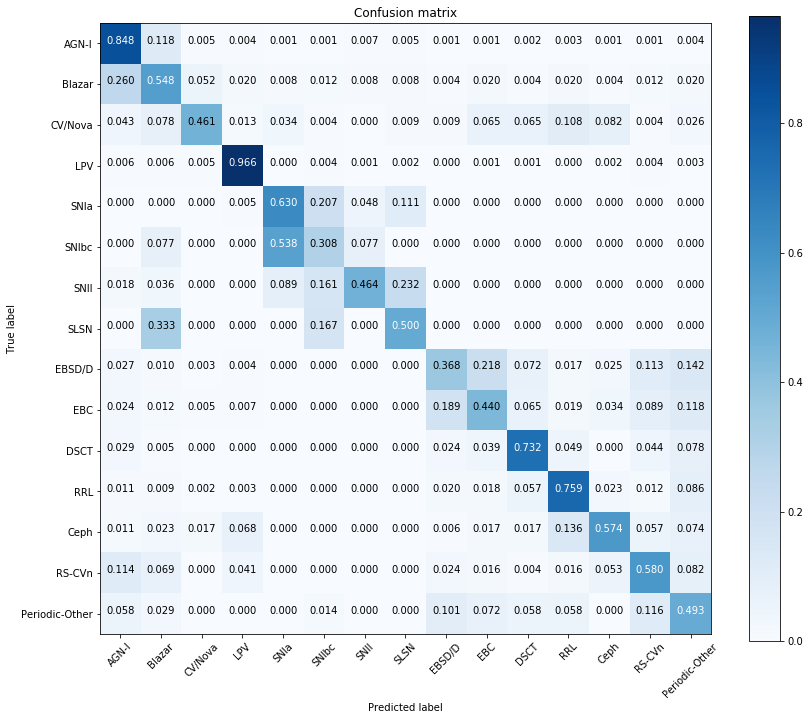

In [21]:
# generating confusion matrix for multilabels

y_true_original = np.concatenate((y_true_stochastic,y_true_periodic,y_true_transient))
y_pred_original = np.concatenate((y_pred_stochastic,y_pred_periodic,y_pred_transient))

cnf_matrix = metrics.confusion_matrix(y_true_original, y_pred_original,labels=cm_classes_original)
print(cnf_matrix)
plot_confusion_matrix(cnf_matrix,cm_classes_original, conf_matrix_name_second_layer)

print("Accuracy:", metrics.accuracy_score(y_true_original, y_pred_original))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_true_original, y_pred_original))

In [22]:
# Kaggle score

prob_final_class_names = np.concatenate((classes_order_proba_stochastic,classes_order_proba_transient,classes_order_proba_periodic))

#prob_final = np.concatenate((y_pred_proba_stochastic,y_pred_proba_transient,y_pred_proba_periodic),axis=1)

'''


x_s = len(y_pred_proba_stochastic[0,:])
y_s = len(y_pred_proba_stochastic[:,0])
x_t = len(y_pred_proba_transient[0,:])
y_t = len(y_pred_proba_transient[:,0])
x_p = len(y_pred_proba_periodic[0,:])
y_p = len(y_pred_proba_periodic[:,0])


prob_stochastic = np.concatenate((y_pred_proba_stochastic,np.zeros((y_s,x_t+x_p))),axis=1)
prob_transient = np.concatenate((np.zeros((y_t,x_s)),y_pred_proba_transient,np.zeros((y_t,x_p))),axis=1)
prob_periodic = np.concatenate((np.zeros((y_p,x_s+x_t)),y_pred_proba_periodic),axis=1)

prob_final = np.concatenate((prob_stochastic,prob_transient,prob_periodic),axis = 0)

'''
from scipy.linalg import block_diag


prob_final = block_diag(y_pred_proba_stochastic, y_pred_proba_transient, y_pred_proba_periodic)



print(prob_final)

num_y_test =  [np.where(prob_final_class_names==x)[0][0] for x in y_test_original] #label_encoder.transform(y_test)

#print(num_y_test)

CLASSES_REDUCED_V2 = prob_final_class_names

def kaggle_loss(labels, predictions, weights=None):
    np.clip(predictions, 10**-15, 1-10**-15, out=predictions)
    classes = np.unique(labels)
    if weights is None:
        weights = np.ones(len(classes), dtype=np.float64)/len(classes)
    loss_sum = 0
    labels = np.array(labels)
    for i in classes:
        p = predictions[labels == i, i]
        class_score = np.mean(np.log(p))*weights[i]
        print(CLASSES_REDUCED_V2[i], class_score)
        loss_sum += class_score
    return -loss_sum/sum(weights)



print(kaggle_loss(num_y_test,prob_final))

[[0.756 0.232 0.002 ... 0.    0.    0.   ]
 [0.006 0.036 0.018 ... 0.    0.    0.   ]
 [0.008 0.086 0.246 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.1   0.578 0.036]
 [0.    0.    0.    ... 0.078 0.026 0.172]
 [0.    0.    0.    ... 0.054 0.014 0.12 ]]
AGN-I -1.4990673927858875
Blazar -1.362586562094134
CV/Nova -1.4912933821906154
LPV -1.4063032901103119
SLSN -2.3025850929940455
SNII -2.2630262321905614
SNIa -2.259886107968012
SNIbc -2.3025850929940446
Ceph -1.146709250735136
DSCT -0.9313765329657188
EBC -1.0983674104652892
EBSD/D -1.044822077639383
Periodic-Other -0.934715744218832
RRL -1.0844644207625433
RS-CVn -1.1964546088328722
22.324243198947393


  ## Classifying unlabeled data

In [1]:
#loading the data

rm_nd_cols = ['n_det_fid_1', 'n_det_fid_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
             'Mean_1','Mean_2']

df_feat_ul = df_feat.drop(rm_nd_cols, axis=1)
df_feat_ul.fillna(-999,inplace=True)

if morethan5:
    df_feat_ul = df_feat_ul[(df_feat_ul.n_samples_1 > 5) & (df_feat_ul.n_samples_2 > 5)]
    
#df_feat_ul_stochastic = df_feat_ul

#df_feat_ul = df_feat_ul.drop(['Mean_2'], axis=1)

#df_feat_ul_stochastic.head()
print(df_feat_ul.shape)

NameError: name 'df_feat' is not defined

In [24]:
#predicting classes of unlabeled data

test_Y_hierarchical = rf_model_hierarchical.predict(df_feat_ul)
test_Y_proba_hierarchical = rf_model_hierarchical.predict_proba(df_feat_ul)

# separating the clasess

test_X_periodic = df_feat_ul[np.where(test_Y_hierarchical=='Periodic')[0][0],:]
test_X_stochastic = df_feat_ul[np.where(test_Y_hierarchical=='Stochastic')[0][0],:]
test_X_transient = df_feat_ul[np.where(test_Y_hierarchical=='Transient')[0][0],:]

test_Y_proba_hierarchical_periodic = test_Y_proba_hierarchical[np.where(test_Y_hierarchical==0)[0]]
test_Y_proba_hierarchical_stochastic = test_Y_proba_hierarchical[np.where(test_Y_hierarchical==1)[0]]
test_Y_proba_hierarchical_transient = test_Y_proba_hierarchical[np.where(test_Y_hierarchical==2)[0]]


,class_original,class_hierachical,sgscore1,delta_mag_fid_1,delta_mag_fid_2,delta_mjd_fid_1,delta_mjd_fid_2,dmag_first_det_fid_1,dmag_first_det_fid_2,dmag_non_det_fid_1,...,Pvar_2,ExcessVar_2,SF_ML_amplitude_2,SF_ML_gamma_2,GP_DRW_sigma_2,GP_DRW_tau_2,IAR_phi_2,LinearTrend_2,gal_b,gal_l
oid,,,,,,,,,,,,,,,,,,,,,
ZTF17aacjwvd,EBSD/D,Periodic,0.995625,0.424199,0.378390,271.098183,308.101134,2.543534,2.714242,2.939435,...,1.000000,9.320852e-05,0.241617,0.002623,2.522917e-02,0.255101,0.000084,0.000277,20.470856,185.723835
ZTF17aadecrr,EBSD/D,Periodic,0.995417,0.935824,0.491198,347.994942,304.160069,5.238234,NaN,5.504596,...,1.000000,1.113585e-04,0.249795,0.102750,2.051202e-02,0.620047,0.187446,0.000486,-8.541295,190.823524
ZTF18adaksvf,RS-CVn,Periodic,0.999167,0.229270,0.600738,113.687512,192.702361,2.992945,4.185538,3.222215,...,1.000000,1.268727e-04,0.200540,-0.118095,2.028384e-02,0.525963,0.029509,-0.000960,64.283014,275.075197
ZTF18abtqdih,EBC,Periodic,0.962042,0.355823,0.210677,376.014641,381.944410,6.048240,NaN,5.901356,...,0.231151,-3.693538e-05,0.000000,0.000000,5.421010e-08,0.642937,0.513844,-0.000073,-33.524393,127.583847
ZTF18abshynt,LPV,Stochastic,0.986042,0.000000,0.096107,0.000000,127.756667,2.004425,3.774174,2.004425,...,0.700503,-9.363979e-08,0.000000,0.000000,1.302898e-09,1.001022,0.001090,0.000237,13.026900,9.935559
